In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
#import sklearn.metrics for evaluation
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
#import callbacks for model checkpoint
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:
store_sales=pd.read_csv("train.csv")
store_sales.head(6)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12


#checks for null vaules in the dataset

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


#dropping store and item from the dataset

In [ ]:
store_sales=store_sales.drop(['item','store'],axis=1)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


#converting date from object datatype to datetime datatype

In [ ]:
store_sales['date']=pd.to_datetime(store_sales['date'])

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


#converting date to month and after that sum up the number of items in each month

In [ ]:
#"M" is for month
store_sales['date']=store_sales['date'].dt.to_period("M")
#sum up the number of items based on date and reset index to default
monthly_sales=store_sales.groupby('date').sum().reset_index()

#converting date column to timestamp datatype object

In [ ]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(6)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597


#Visualization of monthly sales

Text(0.5, 1.0, 'Monthly Customer Sales')

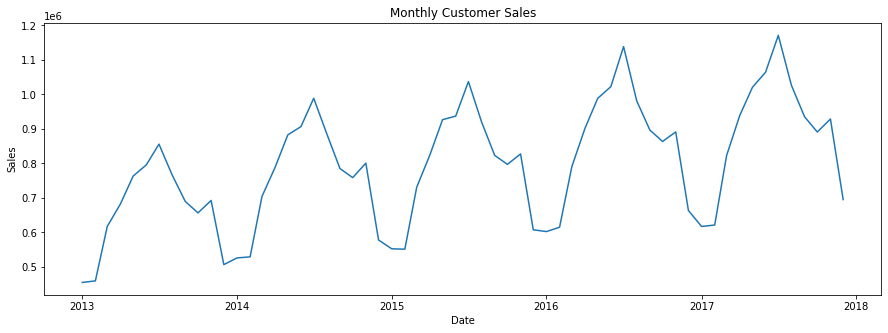

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["date"],monthly_sales["sales"])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")

#call the difference on the sales columns to make data static

In [ ]:
monthly_sales["sales_diff"]=monthly_sales["sales"].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(6)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0


Text(0.5, 1.0, 'Monthly Customer Sales Difference')

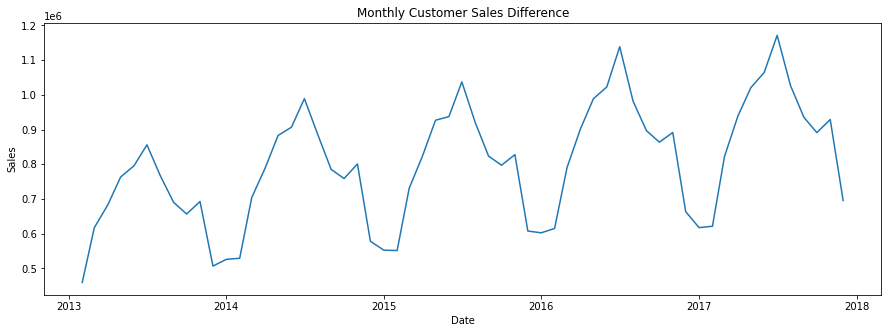

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["date"],monthly_sales["sales"])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")


#dropping of date and sales

In [ ]:
supervised_data=monthly_sales.drop(['date','sales'],axis=1)

#preparing supervised data for the model

In [ ]:
#sales difference for each store each month
for i in range(1,13):
  column_name='month_'+str(i)
  supervised_data[column_name]=supervised_data['sales_diff'].shift()
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(6)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,157965.0,4513.0,4513.0,4513.0,4513.0,4513.0,4513.0,4513.0,4513.0,4513.0,4513.0,4513.0,4513.0
1,64892.0,157965.0,157965.0,157965.0,157965.0,157965.0,157965.0,157965.0,157965.0,157965.0,157965.0,157965.0,157965.0
2,80968.0,64892.0,64892.0,64892.0,64892.0,64892.0,64892.0,64892.0,64892.0,64892.0,64892.0,64892.0,64892.0
3,32355.0,80968.0,80968.0,80968.0,80968.0,80968.0,80968.0,80968.0,80968.0,80968.0,80968.0,80968.0,80968.0
4,60325.0,32355.0,32355.0,32355.0,32355.0,32355.0,32355.0,32355.0,32355.0,32355.0,32355.0,32355.0,32355.0
5,-89161.0,60325.0,60325.0,60325.0,60325.0,60325.0,60325.0,60325.0,60325.0,60325.0,60325.0,60325.0,60325.0


#split data to test and train dataset

In [ ]:
#train for the previous 12 month
train_data=supervised_data[:-12]
#test for the coming 12 month
test_data=supervised_data[-12:]

print("Train data shape: ",train_data.shape)
print("Test data shape: ",test_data.shape)

Train data shape:  (46, 13)
Test data shape:  (12, 13)


In [ ]:
#create a scaler with specific range
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [ ]:
X_train,y_train=train_data[:,1:],train_data[:,0:1]
X_test,y_test=test_data[:,1:],test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
#print output and input
print("X train Shape: ", X_train.shape)
print("Y train Shape: ", y_train.shape)
print("X test Shape: ", X_test.shape)
print("y test Shape: ", y_test.shape)

X train Shape:  (46, 12)
Y train Shape:  (46,)
X test Shape:  (12, 12)
y test Shape:  (12,)


#Make prediction dataframe to merge the predicted sales prices of all trained algorithms

In [ ]:
sales_dates= monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [ ]:
#actual sales of last 13 months
actual_sales=monthly_sales['sales'][-13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


#creation of linear regression model and predicted output

In [ ]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
lr_pred=lr_model.predict(X_test)

In [ ]:
lr_pred=lr_pred.reshape(-1,1)
#matrix set that contains the input fatures of the test data and predicted output
lr_pretest_set=np.concatenate([lr_pred,X_test],axis=1)
lr_pretest_set=scaler.inverse_transform(lr_pretest_set)

In [ ]:
#list predicted vaules from different vaules(sales_diff)
result_list=[]
for index in range(0,len(lr_pretest_set)):
  #append first  index of iterator+actual sales with the iterator 
  result_list.append(lr_pretest_set[index][0]+actual_sales[index])
#series of result list 
lr_pre_series=pd.Series(result_list,name='Linear Prediction')
#merge lr_pre_series if left and right are True
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True)

#evaluation of linear regression model

In [ ]:
#mean squared error
lr_mse=np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
#mean absolute error
lr_mae=mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
#r2 score
lr_r2=r2_score=(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])


print("Linear Regression MSE: ",lr_mse)
print("Linear Regression MAE: ",lr_mae)
print("Linear Regression R2: ",lr_r2)

Linear Regression MSE:  112670.712337325
Linear Regression MAE:  84054.93113485434
Linear Regression R2:  (0     6.193761e+05
1     6.103960e+05
2     6.246962e+05
3     8.662418e+05
4     9.650708e+05
5     1.039881e+06
6     1.076088e+06
7     1.195678e+06
8     9.993146e+05
9     9.191632e+05
10    8.846585e+05
11    9.390235e+05
Name: Linear Prediction, dtype: float64, 48     617306
49     621369
50     822667
51     938862
52    1020686
53    1064624
54    1171393
55    1026403
56     935263
57     891160
58     928837
59     695170
Name: sales, dtype: int64)


#Visualization of prediction vs actual sales

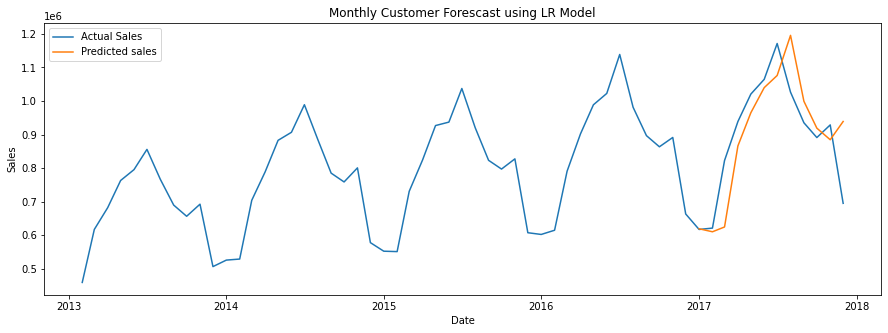

In [ ]:
plt.figure(figsize=(15,5))
#actual sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])
#prediction
plt.plot(predict_df['date'],predict_df['Linear Prediction'])

plt.title("Monthly Customer Forescast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales','Predicted sales'])
plt.show()